In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Model
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Configs
pd.options.display.float_format = '{:,.4f}'.format
sns.set(style="whitegrid")
plt.style.use('seaborn')
seed = 42
np.random.seed(seed)

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
def evalua(y_test,pred):
    print('Confusion matrix:\n',confusion_matrix(y_test,pred),'\n')
    print('Classification report:\n',classification_report(y_test,pred),'\n')
    print('Accuracy:',accuracy_score(y_test,pred),'\n')

In [3]:
# Load data
file_path = '/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)
print("DataSet = {:,d} rows and {} columns".format(df.shape[0], df.shape[1]))

print("\nAll Columns:\n=>", df.columns.tolist())

quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']
del qualitative[-1]

print("\nStrings Variables:\n=>",qualitative ,
      "\n\nNumerics Variables:\n=>", quantitative)

df.head(3)

DataSet = 7,043 rows and 21 columns

All Columns:
=> ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Strings Variables:
=> ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges'] 

Numerics Variables:
=> ['SeniorCitizen', 'tenure', 'MonthlyCharges']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.8500,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.9500,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.8500,108.15,Yes


In [4]:
# Transform data

df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)

df = df.dropna()
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
# String to numeric (TCA)
df1=df.Churn
for i in qualitative:
    spd1=pd.DataFrame(df.groupby(df[i]).mean().Churn)
    auxiliar=spd1.to_dict()
    spd2=df[i].map(auxiliar.get('Churn'))
    df1=pd.DataFrame(df1).join(pd.DataFrame(spd2))

In [6]:
# Create numeric data frame
df2=df[quantitative]
df=pd.DataFrame(df1).join(pd.DataFrame(df2))

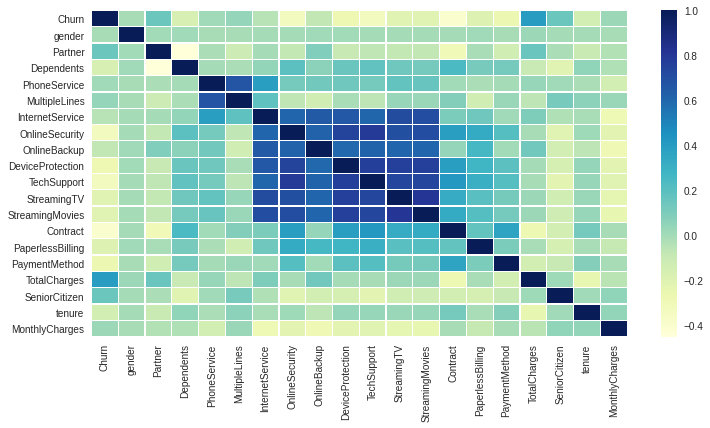

In [7]:
# Correlation analysis plot
plt.figure(figsize=(12, 6))
df.drop(['customerID'], axis=1, inplace=True)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

In [8]:
corr['Churn'].sort_values(ascending=True)

Contract           -0.3967
OnlineSecurity     -0.3328
TechSupport        -0.3299
DeviceProtection   -0.2815
PaymentMethod      -0.2628
StreamingMovies    -0.2073
StreamingTV        -0.2057
PaperlessBilling   -0.1918
Dependents         -0.1642
tenure             -0.1444
OnlineBackup       -0.0742
InternetService    -0.0473
gender             -0.0086
PhoneService        0.0119
MonthlyCharges      0.0210
MultipleLines       0.0363
Partner             0.1504
SeniorCitizen       0.1509
TotalCharges        0.3989
Churn               1.0000
Name: Churn, dtype: float64

In [9]:
# Samples
x = df.drop(['Churn'], axis=1)
y = df['Churn']
x_train, x_test, y_train, y_test = train_test_split(x, y.values, test_size=0.20, random_state=42)

In [10]:
# Search model
random_search = {
               'criterion': ['entropy', 'gini'],
               'max_depth': [2,3,4,5],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [10,30,50],
               'n_estimators': [60,80,100]}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 50, 
                               cv = 6, verbose= 1, random_state= 101, n_jobs = 10)
model.fit(x_train,y_train)

# Training 
print('Training:')
evalua(y_train,model.predict(x_train))

Fitting 6 folds for each of 50 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   29.0s
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:   42.4s finished


Training:
Confusion matrix:
 [[4100   38]
 [  54 1442]] 

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4138
           1       0.97      0.96      0.97      1496

    accuracy                           0.98      5634
   macro avg       0.98      0.98      0.98      5634
weighted avg       0.98      0.98      0.98      5634
 

Accuracy: 0.9836705715299965 



In [11]:
# the best estimator
print('Our best model:',model.best_estimator_)

Our best model: RandomForestClassifier(max_depth=5, min_samples_leaf=10, n_estimators=60)


In [12]:
# Test
print('Testing:')
pred=model.predict(x_test)
evalua(y_test,pred)

Testing:
Confusion matrix:
 [[1024   12]
 [  18  355]] 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1036
           1       0.97      0.95      0.96       373

    accuracy                           0.98      1409
   macro avg       0.98      0.97      0.97      1409
weighted avg       0.98      0.98      0.98      1409
 

Accuracy: 0.978708303761533 



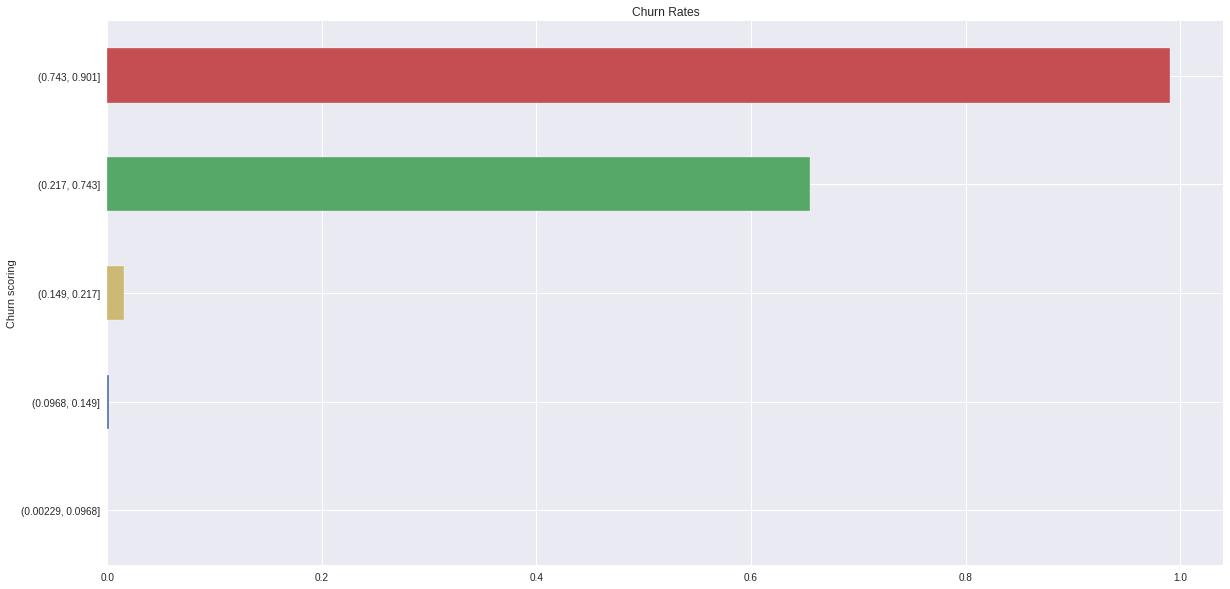

In [13]:
# Target for marketing
churn_scoring=model.predict_proba(x)
cuts=np.percentile(churn_scoring[:,1],[0,50,60,70,80,100])
df['Churn scoring']=pd.cut(np.array(churn_scoring[:,1]),cuts)
dfs=df.groupby('Churn scoring').mean()['Churn']
dfs.plot(kind='barh',title='Churn Rates',color=['r','b','y','g'],figsize=(20,10),grid=bool)

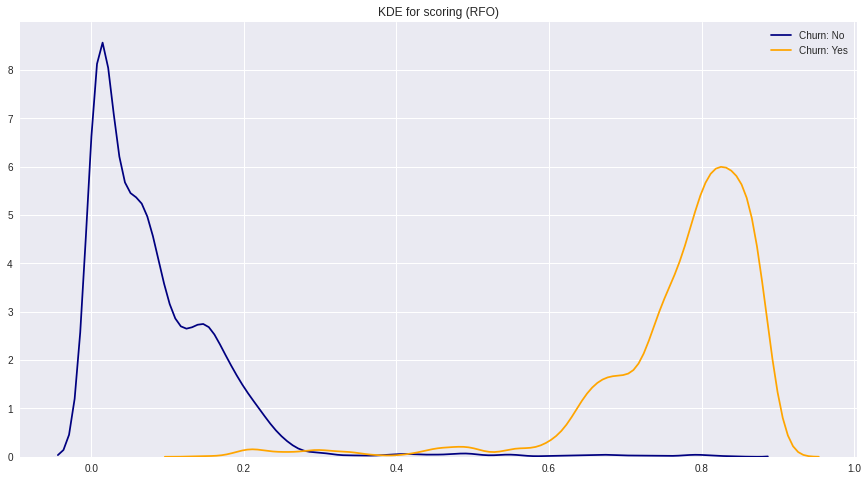

In [14]:
# Model performance
df['Scoring']=churn_scoring[:,1]
plt.figure(figsize=(15, 8))
plt.title("KDE for scoring (RFO)")
ax0 = sns.kdeplot(df[df['Churn'] == 0]['Scoring'].dropna(), color= 'navy', label= 'Churn: No')
ax1 = sns.kdeplot(df[df['Churn'] == 1]['Scoring'].dropna(), color= 'orange', label= 'Churn: Yes')